The following is the notebook of code written by H. Passmore for the assessment and tuning of Machine Learning algorithms for Capstone 1: Amazon Book Reviews & Ratings Predictor. 

# Machine Learning Algorithms for Capstone 1
_Amazon Book Reviews & Ratings Predictor_

_Machine Learning Code_
***

### Below is the code for assessing and tuning machine learning algorithms to predict ratings from reviews.

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm

# Build figures inline
%matplotlib inline

In [2]:
# Setup Pandas  
pd.set_option('display.width', 350)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [77]:
# bring the book_revs dataframe into workspace from the inferential statistics code
# import pickle
# load the pickled  DataFrame of Science Textbook Reviews from hard drive in 'rb' mode
import pickle
with open('book_revs_forML.pickle','rb') as f:
    book_revs = pickle.load(f)

### Check dataframe of ratings and review text

In [78]:
# check input data for Machine Learning: reviewText and rating_cat
book_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11546 entries, 0 to 11545
Data columns (total 9 columns):
asin           11546 non-null object
overall        11546 non-null int64
reviewText     11546 non-null object
summary        11546 non-null object
five_not5      11546 non-null object
rating_cat     11546 non-null int64
token_count    11546 non-null int64
caps_count     11546 non-null int64
pct_caps       11546 non-null float64
dtypes: float64(1), int64(4), object(4)
memory usage: 811.9+ KB


In [79]:
# keep only what we need
rev_rate = book_revs.drop(['asin', 'overall', 'summary', 'five_not5', 'token_count', 'caps_count', 'pct_caps'], axis=1)
rev_rate.head(2)

,reviewText,rating_cat
0,This is a good book for the science nerd and t...,0
1,"If you're a biology/genetics enthusiast, this ...",1


In [117]:
# This fixed the string problem. Applied to 'clean_revs'. Move down?
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(str)
rev_rate.head()

,reviewText,rating_cat,clean_revs
0,This is a good book for the science nerd and t...,0,"['good', 'scienc', 'nerd', 'non', 'scienc', 'a..."
1,"If you're a biology/genetics enthusiast, this ...",1,"['biolog', 'genet', 'enthusiast', 'great', 'of..."
2,I bought this for my daughter who borrowed all...,0,"['bought', 'daughter', 'borrow', 'frank', 'mcc..."
3,This book was recommended by a tour guide in I...,0,"['recommend', 'tour', 'guid', 'ireland', 'extr..."
4,Our school recently upgraded to this chemistry...,1,"['school', 'recent', 'upgrad', 'chemistri', 'h..."


## Implement tools to Reduce Document Dimensions

In [60]:
# Implement SnowballStemmer and build CountVectorizer with tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem.snowball import SnowballStemmer

In [81]:
import string
user_defined_stop_words = ['book', 'books', 'read', 'reading']

i = stopwords.words('english')
j = list(string.punctuation) + user_defined_stop_words

stopwords = set(i).union(j)

In [82]:
# define preprocessor
def preprocess(x):
    letters_only = re.sub('[^a-zA-Z]', ' ', str(x))                  # keep alpha only
    words = letters_only.lower().split()                            # lowercase everything  
    useful_words = [w for w in words if w not in set(stopwords)]    # remove stopwords
    return (' '.join(useful_words))

In [83]:
# apply preprocessor to review text
rev_rate['clean_revs'] = rev_rate['reviewText'].apply(preprocess)
rev_rate.tail()

,reviewText,rating_cat,clean_revs
11541,Definitely a MUST-READ if you are a home cooki...,1,definitely must home cooking enthusiast want g...
11542,Pros: Scientifically informative and solid. Kn...,0,pros scientifically informative solid knowing ...
11543,Real fun to read. For everybody that is inters...,0,real fun everybody intersted cooking certain p...
11544,This book will teach you the chemical secrets ...,0,teach chemical secrets techniques usually used...
11545,I paid more than $30 to buy such a superficial...,0,paid buy superficial trivial made big mistake ...


In [109]:
type(rev_rate['clean_revs'])

pandas.core.series.Series

In [112]:
#from nltk.stem.porter import PorterStemmer
# instantiate the stemmer
stemmer = SnowballStemmer("english")
#stemmer = PorterStemmer()

In [113]:
# define second preprocessor for tokenization and stemming
def preprocess2(text):
    stemmer = SnowBallStemmer("english", ignore_stopwords=True)
    tokens = word_tokenize(text)
    stems = [stemmer.stem_word(t) for t in tokens]
    return stems

In [319]:
rev_rate['clean_revs'] = rev_rate['clean_revs'].apply(preprocess2)
rev_rate.tail()

In [118]:
rev_rate.clean_revs[:8]

0    ['good', 'scienc', 'nerd', 'non', 'scienc', 'a...
1    ['biolog', 'genet', 'enthusiast', 'great', 'of...
2    ['bought', 'daughter', 'borrow', 'frank', 'mcc...
3    ['recommend', 'tour', 'guid', 'ireland', 'extr...
4    ['school', 'recent', 'upgrad', 'chemistri', 'h...
5    ['confus', 'explain', 'poor', 'overal', 'graph...
6    ['lot', 'cool', 'experi', 'complet', 'fun', 'p...
7    ['great', 'condit', 'better', 'expect', 'ship'...
Name: clean_revs, dtype: object

In [119]:
my_text = rev_rate['clean_revs']

In [100]:
# import RegexpTokenizer from nltk.tokenize
from nltk.tokenize import RegexpTokenizer

# Create tokenizer
tokenizer = RegexpTokenizer('\w+')

In [120]:
my_text[:8]

0    ['good', 'scienc', 'nerd', 'non', 'scienc', 'a...
1    ['biolog', 'genet', 'enthusiast', 'great', 'of...
2    ['bought', 'daughter', 'borrow', 'frank', 'mcc...
3    ['recommend', 'tour', 'guid', 'ireland', 'extr...
4    ['school', 'recent', 'upgrad', 'chemistri', 'h...
5    ['confus', 'explain', 'poor', 'overal', 'graph...
6    ['lot', 'cool', 'experi', 'complet', 'fun', 'p...
7    ['great', 'condit', 'better', 'expect', 'ship'...
Name: clean_revs, dtype: object

In [320]:
# Create tokens
tokens = tokenizer.tokenize(my_text)
tokens[:8]

In [123]:
# Create freq dist of tokens and plot
#freqdist1 = nltk.FreqDist(my_text)
#freqdist1.plot(25)

## Create X & y, split train and test data sets

In [124]:
# store the feature matrix (X) and response vector (y) 
# uppercase X because it's an m x n matrix
X = rev_rate.clean_revs

# lowercase y because it's a m x 1 vector
y = rev_rate.rating_cat

print(X.shape)
print(y.shape)

(11546,)
(11546,)


In [125]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 8659
X Testing set sample size: 2887
y Training set sample size: 8659
y Testing set sample size: 2887


In [126]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.336412980714
0.336335296155


In [127]:
print(X_train[0:2])

7665    ['rainforest', 'grew', 'around', 'susan', 'k',...
1141    ['consequ', 'develop', 'electron', 'superintel...
Name: clean_revs, dtype: object


## Vectorize, fit, output document-term matrix with two vectorizers

In [128]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate two vectorizers
vect = CountVectorizer(stop_words='english', lowercase=False, analyzer='word', tokenizer=None) 
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7, lowercase=False)

In [129]:
# Apply CountVectorizer ('vect') to stemmed tokens to learn training data vocabulary
# then use it to create a document-term matrix
#import ipdb 
#ipdb.set_trace()
X_train_dtm = vect.fit_transform(X_train.values)

# examine the document-term matrix
X_train_dtm

<8659x20687 sparse matrix of type '<class 'numpy.int64'>'
	with 386212 stored elements in Compressed Sparse Row format>

In [130]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test.values)
X_test_dtm

<2887x20687 sparse matrix of type '<class 'numpy.int64'>'
	with 125116 stored elements in Compressed Sparse Row format>

In [131]:
# Apply TfidfVectorizer to learn training data vocabulary
# then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train.values)

# examine the document-term matrix
X_train_tfidf

<8659x20687 sparse matrix of type '<class 'numpy.float64'>'
	with 386212 stored elements in Compressed Sparse Row format>

In [132]:
# view current parameters for CountVectorizer 'vect'
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [133]:
# view current parameters for TfidfVectorizer 'tfidf'
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.7, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [134]:
# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test.values)
X_test_tfidf

<2887x20687 sparse matrix of type '<class 'numpy.float64'>'
	with 125116 stored elements in Compressed Sparse Row format>

## First, build the simple model with Naive Bayes for baseline

In [293]:
# import and instantiate scikit-learn's MultinomialNB() classifier to use on CountVec vectors
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=1, fit_prior=True)

In [294]:
# train the model using X_train_dtm from CountVectorizer (vect)
%time nb.fit(X_train_dtm, y_train)

CPU times: user 12.5 ms, sys: 23.6 ms, total: 36.1 ms
Wall time: 65.8 ms


MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [287]:
# COMPARE TFIDF VECTORIZER
# import and instantiate scikit-learn's MultinomialNB() classifier to use on tfidf vectors
nbtfidf = MultinomialNB(alpha=0.1, fit_prior=True) # parameters from GridSearchCV

In [288]:
# COMPARE TFIDF VECTORIZER
# train the model using X_train_tfidf from TfidfVectorizer
%time nbtfidf.fit(X_train_tfidf, y_train)

CPU times: user 12.7 ms, sys: 31 ms, total: 43.7 ms
Wall time: 162 ms


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [295]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
from sklearn import metrics

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_class)

0.80862403100775182

In [290]:
# COMPARE TFIDF VECTORIZER
# make class predictions for X_test_dtm
y_pred_tfidf = nbtfidf.predict(X_test_tfidf)

# calculate F1 Score: a weighted average of the precision and recall (est value at 1 and worst score at 0)
metrics.f1_score(y_test, y_pred_tfidf)

0.81068524970963995

In [296]:
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 428,  543],
       [ 247, 1669]])

Confusions Matrix breakdown for Count Vectorizer with Naive Bayes:
True Positives: 1669 reviews correctly predicted as 'five'
True Negatives: 428 reviews correctly predicted as 'not5'
False Positives: 543 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 247 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

In [307]:
# COMPARE TFIDF VECTORIZER
# print the confusion matrix from Count Vectorizer
metrics.confusion_matrix(y_test, y_pred_tfidf)

array([[ 327,  644],
       [ 171, 1745]])

Confusions Matrix breakdown for TFIDF Vectorizer with Naive Bayes:
True Positives: 1912 reviews correctly predicted as 'five'
True Negatives: 49 reviews correctly predicted as 'not5'
False Positives: 922 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 4 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

In [297]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([ 0.94360695,  0.97787419,  0.60781163, ...,  0.98560902,
        0.9950169 ,  0.99663294])

In [144]:
# COMPARE TFIDF VECTORIZER
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob_tfidf = nbtfidf.predict_proba(X_test_tfidf)[:, 1]
y_pred_prob_tfidf

array([ 0.86438577,  0.88594022,  0.61898136, ...,  0.92859884,
        0.87987798,  0.87676254])

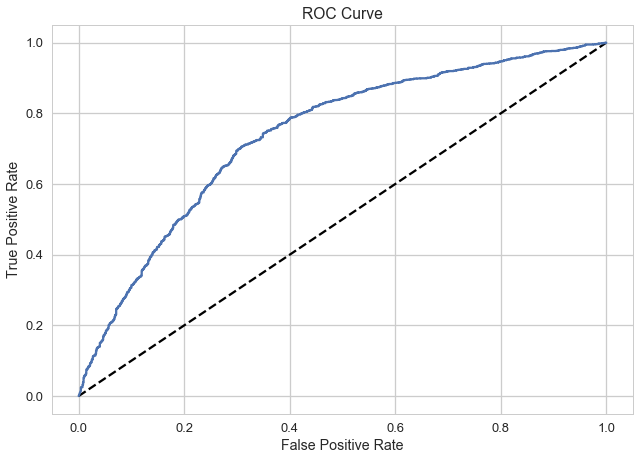

In [298]:
# Import roc_curve module
from sklearn.metrics import roc_curve

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [299]:
# calculate AUC for simple model
metrics.roc_auc_score(y_test, y_pred_prob)

0.73920790610373055

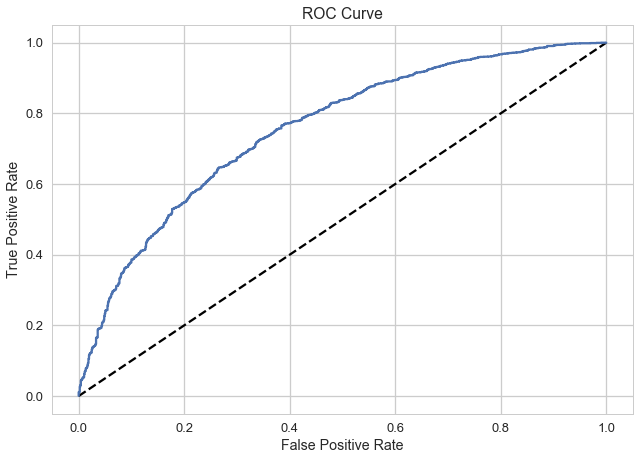

In [147]:
# COMPARE TFIDF VECTORIZER
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_tfidf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [148]:
# COMPARE TFIDF VECTORIZER
# calculate AUC for simple model
metrics.roc_auc_score(y_test, y_pred_prob_tfidf)

0.75528102014796528

### Run GridSearchCV on best parameters for CountVectorizer

In [300]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {#'ngram_range': [(1, 1), (1, 2), (1,3)], 
              #'max_df': (0.5, 0.75, 1.0),
              #'vect__max_features': [1, 3, 10],
              #'min_df' :(0.00001,0.0001,0.001,0.01,1),
              'fit_prior': (True, False),
              #'class_prior': (True, False), 
              'alpha': (0.001, 0.1, 1, 5, 10)
             }
        

In [164]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [301]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_mnb = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1)
gs_mnb = gs_mnb.fit(X_train_dtm, y_train)

In [302]:
# View the best score (set to roc_auc)
print('Best score for text:', gs_mnb.best_score_) 

Best score for text: 0.74052367772


In [303]:
# Get best parameters
print('Best parameters:', gs_mnb.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True

Best parameters: {'alpha': 1, 'fit_prior': True}


### Run GridSearchCV on best parameters for TfidfVectorizer

In [304]:
# fit grid search agian with DTM for tfidf vectorizer
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', n_jobs=-1)
gs_tfidf = gs_tfidf.fit(X_train_tfidf, y_train)

In [305]:
# View the best score (set to roc_auc)
print('Best score for text:', gs_tfidf.best_score_) 

Best score for text: 0.75392597948


In [306]:
# Get best parameters
print('Best parameters:', gs_tfidf.best_params_)
# Alpha = 0.1 is the default and picked as best alpha
# fit_prior: True

Best parameters: {'alpha': 0.1, 'fit_prior': True}


## Examine model inputs for further insight

In [179]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

20687

In [180]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['aa', 'aaa', 'aaaah', 'aacut', 'aah', 'aar', 'aardvark', 'aarhus', 'aaron', 'aayah', 'ab', 'ababa', 'aback', 'abacus', 'abandon', 'abat', 'abbi', 'abbrevi', 'abc', 'abd', 'abdomen', 'abduct', 'abe', 'abeauti', 'abeka', 'aberr', 'abet', 'abettor', 'abhor', 'abid', 'abil', 'abilitiesth', 'abilityto', 'abiogenesi', 'abism', 'abit', 'abject', 'abl', 'ableto', 'abli', 'abneg', 'abnorm', 'aboard', 'abod', 'abolish', 'abolit', 'abomin', 'aboot', 'aborigin', 'abort']


In [181]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['zeigfeld', 'zelazni', 'zelaznysci', 'zelda', 'zen', 'zeno', 'zephirus', 'zermello', 'zermelo', 'zero', 'zeroeth', 'zerpa', 'zeta', 'zettel', 'zeus', 'zfc', 'zhul', 'zhumel', 'zig', 'ziggi', 'zigzag', 'zillion', 'zinc', 'zinn', 'zinsser', 'zionism', 'zionist', 'zip', 'zipf', 'zirbel', 'zirconium', 'zither', 'zodiac', 'zolin', 'zoloft', 'zombi', 'zone', 'zoo', 'zoobiqu', 'zoolog', 'zoologist', 'zoom', 'zoonic', 'zoonom', 'zoonos', 'zoonosi', 'zoonot', 'zumba', 'zumdahl', 'zweikant']


__Interpretation of simple model:__ The Naive Bayes model trained on stemmed tokens with stop words removed performs fairly well. GridSearchCV indicates the best parameters for the two vectorizers. For the rest of the algorithms I will use the document terms matrix from the XXXXXX vectorizer based on the comparisons above.

## Fit Random Forest classifier, get feature importance

In [215]:
# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# classifier with grid search parameters (multiple runs to target best parameters)
rf_clf = RandomForestClassifier(max_features=300, min_samples_leaf=5).fit(X_train_dtm, y_train)

predicted_rf_clf = rf_clf.predict(X_test_dtm)

metrics.f1_score(y_test, predicted_rf_clf)

0.80904977375565612

In [216]:
# print the confusion matrix These changed on a new run. Do I need to set random state?
metrics.confusion_matrix(y_test, predicted_rf_clf)

array([[ 255,  716],
       [ 128, 1788]])

Confusions Matrix breakdown:
True Positives: 1551 reviews correctly predicted as 'five'
True Negatives: 410 reviews correctly predicted as 'not5'
False Positives: 561 reviews incorrectly predicted to be 'five' but they are 'not5' (Type I error).
False Negatives: 395 reviews incorrectly predicted to be 'not5' but they are 'five' (Type II error).

In [217]:
# print the classification report for stemmed Random Forest model
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_rf_clf))

             precision    recall  f1-score   support

          0       0.67      0.26      0.38       971
          1       0.71      0.93      0.81      1916

avg / total       0.70      0.71      0.66      2887



In [218]:
# calculate predicted probabilities for X_test_dtm from CountVectorizer
y_pred_prob_rf_clf = rf_clf.predict_proba(X_test_dtm)[:, 1]
y_pred_prob_rf_clf

array([ 0.84800843,  0.6824458 ,  0.41206151, ...,  0.87380668,
        0.85295291,  0.8336092 ])

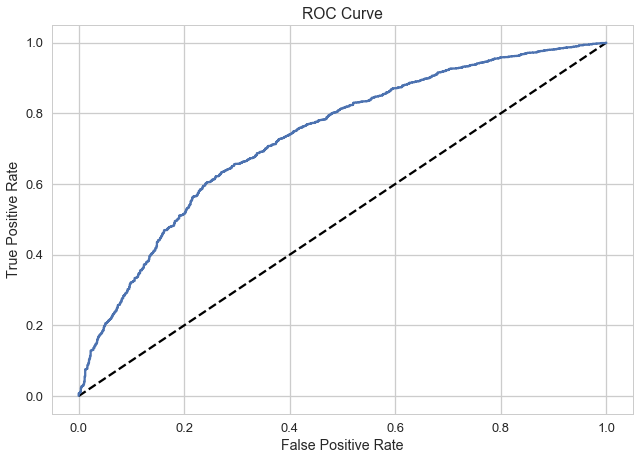

In [219]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf_clf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [220]:
# calculate AUC for stemmed randomforest model
metrics.roc_auc_score(y_test, y_pred_prob_rf_clf)

0.73208860718670243

In [188]:
# use to get a list of the all available pipe-items unique keys for the grid parameters
sorted(rf_clf.get_params().keys())

['bootstrap',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [209]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
params = {#'vect__ngram_range': [(1, 1), (1, 2), (1,3)], 
              #'vect__max_df': (0.5, 0.75, 1.0),
              'max_features': [100, 150, 200, 250, 300, 400, 500],
              #'vect__min_df' :(0.00001,0.0001,0.001,0.01,1),
              'min_samples_leaf': (3, 5),
              #'min_samples_split': (1, 3, 10),
              #'tfidf__use_idf': (True, False), 
              #'mnb__alpha': (0.1, 1, 5, 10)
         }

In [210]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train_dtm, y_train) 

In [211]:
# View the best accuracy score
print('Best score for text:', gs_rf.best_score_) 
# prior run gave: Best score for text: 0.737

Best score for text: 0.73741873089


In [212]:
# Get best parameters
print('Best parameters:', gs_rf.best_params_)
# prior run gave: Best parameters: {'max_features': 300, 'min_samples_leaf': 5} first run gave 10 & 3

Best parameters: {'max_features': 300, 'min_samples_leaf': 5}


In [214]:
# looking into classifier
#print(rf_clf.steps[2])

In [221]:
# get array of Random Forest feature importances
rf_clf.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [254]:
import eli5
eli5.show_weights(rf_clf, vec=vect, top=20, target_names=y_test)

Weight,Feature
0.0186 ± 0.0304,love
0.0173 ± 0.0369,howev
0.0163 ± 0.0251,expect
0.0159 ± 0.0405,like
0.0153 ± 0.0202,disappoint
0.0142 ± 0.0224,good
0.0132 ± 0.0177,great
0.0106 ± 0.0245,bit
0.0106 ± 0.0230,unfortun
0.0089 ± 0.0171,high


In [259]:
# this didn't work
# eli5.show_prediction(rf_clf, X_test_dtm[1], vec=vect, target_names=y_test)

In [ ]:
# need to finish getting most important features
# run statistical comparisons of results between categories

## Build pipeline to fit LogisticRegressionCV classifier

In [311]:
# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

# Logistic Regression CV classifier.
logreg_clf = LogisticRegressionCV(scoring='roc_auc').fit(X_train_dtm, y_train)

predicted_logreg_clf = logreg_clf.predict(X_test_dtm)

metrics.f1_score(y_test, predicted_logreg_clf)

0.82971698113207548

In [312]:
# print the confusion matrix These changed on a new run. Do I need to set random state?
metrics.confusion_matrix(y_test, predicted_logreg_clf)

array([[ 406,  565],
       [ 157, 1759]])

In [313]:
# print the classification report for stemmed Logistic Regression model
print(classification_report(y_test, predicted_logreg_clf))

             precision    recall  f1-score   support

          0       0.72      0.42      0.53       971
          1       0.76      0.92      0.83      1916

avg / total       0.74      0.75      0.73      2887



In [314]:
# calculate predicted probabilities for X_test with stemmed Logistic Regression model
y_pred_prob_logreg_clf = logreg_clf.predict_proba(X_test_dtm)[:, 1]
y_pred_prob_logreg_clf

array([ 0.77964661,  0.71759707,  0.4439792 , ...,  0.81872248,
        0.87527036,  0.83727281])

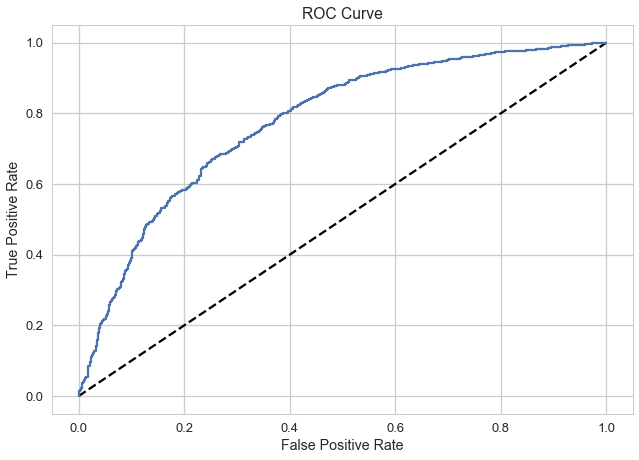

In [315]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg_clf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [316]:
# calculate AUC for LogisticRegressionCV classifier
metrics.roc_auc_score(y_test, y_pred_prob_logreg_clf)

0.77583910438198356

In [317]:
import eli5
eli5.show_weights(logreg_clf, vec=vect, top=20, target_names=y_test)

In [318]:
logreg_clf

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

## Fit Support Vector Machines classifier

In [282]:
# try fitting with Support Vector Machines (SVM) algorithm
from sklearn.linear_model import SGDClassifier

clf_svm = SGDClassifier(max_iter=5, tol=None, alpha=0.01, random_state=42).fit(X_train_dtm, y_train)

predicted_svm = clf_svm.predict(X_test_dtm)

metrics.f1_score(y_test, predicted_svm)

0.82996712071395018

In [283]:
# print the confusion matrix These changed on a new run. Do I need to set random state?
metrics.confusion_matrix(y_test, predicted_svm)

array([[ 396,  575],
       [ 149, 1767]])

In [284]:
# print the classification report for stemmed Logistic Regression model
print(classification_report(y_test, predicted_svm))

             precision    recall  f1-score   support

          0       0.73      0.41      0.52       971
          1       0.75      0.92      0.83      1916

avg / total       0.75      0.75      0.73      2887



In [273]:
# calculate predicted probabilities for X_test_dtm with stemmed Logistic Regression model
y_pred_prob_clf_svm = clf_svm.predict_proba(X_test_dtm)[:, 1]
y_pred_prob_clf_svm

# AttributeError: probability estimates are not available for loss='hinge'
# Therefore cannot graph ROC curve?

In [285]:
# calculate AUC
metrics.roc_auc_score(y_test, predicted_svm)

0.66503040147578307

In [275]:
# get a list of the all available pipe-items unique keys for the grid parameters
sorted(clf_svm.get_params().keys())

['alpha',
 'average',
 'class_weight',
 'epsilon',
 'eta0',
 'fit_intercept',
 'l1_ratio',
 'learning_rate',
 'loss',
 'max_iter',
 'n_iter',
 'n_jobs',
 'penalty',
 'power_t',
 'random_state',
 'shuffle',
 'tol',
 'verbose',
 'warm_start']

In [277]:
# apply GridSearchCV

# create a list of performace parameters for performace tuning (ngram range, use idf?, best alpha)
parameters = {'alpha': (1, 0.1, 1e-2, 1e-3)}

In [278]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_svm = GridSearchCV(SGDClassifier(max_iter=5, tol=None, random_state=42), parameters, n_jobs=-1)
gs_svm = gs_svm.fit(X_train_dtm, y_train)
# cannot set scoring to F1 or roc_auc

In [280]:
# View the best accuracy score
print('Best score for text:', gs_svm.best_score_) 

Best score for text: 0.751010509297


In [281]:
# View the best parameters
print('Best parameters:', gs_svm.best_params_) 
Best parameters: {'alpha': 0.01}

Best parameters: {'alpha': 0.01}
